In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from wordcloud import WordCloud


In [ ]:
# torch imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer


In [ ]:
# NLTK specific imports and downloads

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Class for CNN

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded = self.tokenizer(text, padding='max_length', truncation=True,
                               max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


CNN Model Architecture

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max(pool, dim=2)[0] for pool in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


Data Preprocessing Function

In [ ]:
def preprocess_text(comment):
    comment = comment.lower()
    comment = re.sub(r'[^a-zA-Z\s]', '', comment)
    words = word_tokenize(comment)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


Model Training and Evaluation Functions

In [ ]:
def train_logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nLogistic Regression Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return model, y_pred

def train_random_forest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    print("\nRandom Forest Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return rf_model, y_pred

def train_svm_models(X_train, X_test, y_train, y_test):
    kernels = ['linear', 'poly', 'rbf']
    svm_accuracy = {}
    best_model = None
    best_pred = None
    best_acc = 0

    for k in kernels:
        svm = SVC(kernel=k)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        svm_accuracy[k] = acc
        if acc > best_acc:
            best_acc = acc
            best_model = svm
            best_pred = y_pred
        print(f"\nSVM Kernel Function: {k}\n", classification_report(y_test, y_pred))

    print("\nSVM Accuracies:")
    for kernel, acc in svm_accuracy.items():
        print(f"SVM Kernel Function: {kernel}, Accuracy: {acc*100:.1f}")

    return best_model, best_pred

def train_xgboost(X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    print("\nXGBoost Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return xgb_model, y_pred

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


CNN Training and Evaluation Functions

In [ ]:
def train_cnn(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)

def evaluate_cnn(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)


Visualization Functions

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title('CNN Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('CNN Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_model_comparison(accuracies_dict):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(accuracies_dict.keys(), accuracies_dict.values(),
                  color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
# Word Cloud Visualization

def plot_word_cloud(text_data, title='Word Cloud'):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stopwords.words('english')).generate(' '.join(text_data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

In [ ]:
# Plot distribution of target classes (Spam vs Non-Spam)

def plot_target_distribution(y_data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_data, palette='Set2')
    plt.title('Distribution of Spam and Non-Spam Comments')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Spam', 'Spam'])
    plt.show()

In [ ]:
# Plot top N most frequent words in the dataset

def plot_word_frequency(text_data, top_n=20):
    all_words = ' '.join(text_data)
    all_words = re.sub(r'[^a-zA-Z\s]', '', all_words)  # Clean the text
    word_freq = pd.Series(all_words.split()).value_counts().head(top_n)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Plot the distribution of comment lengths

def plot_comment_length_distribution(text_data):
    comment_lengths = text_data.apply(lambda x: len(x.split()))

    plt.figure(figsize=(8, 6))
    sns.histplot(comment_lengths, kde=True, bins=30, color='skyblue')
    plt.title('Distribution of Comment Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()


<ipython-input-12-66ceab36152d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette='Set2')


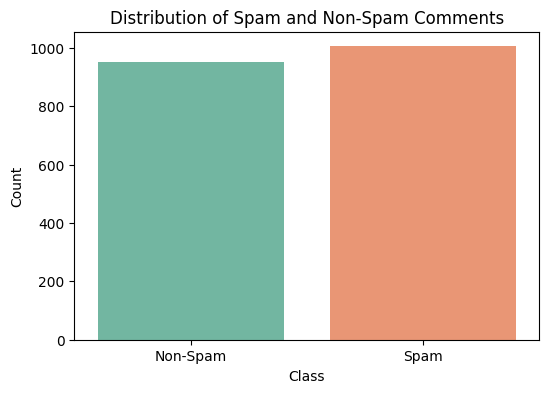

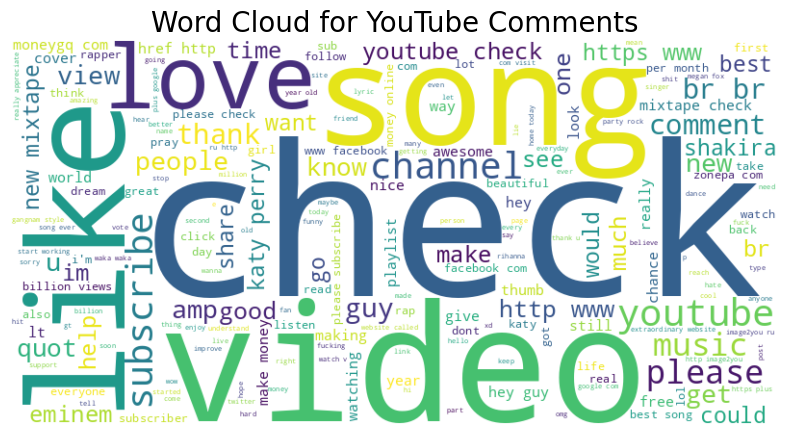

<ipython-input-13-a9f9afc6ec24>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')


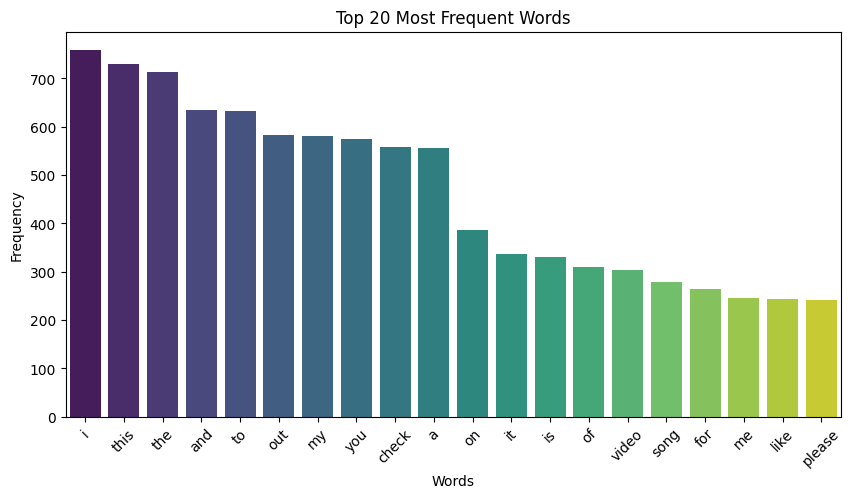

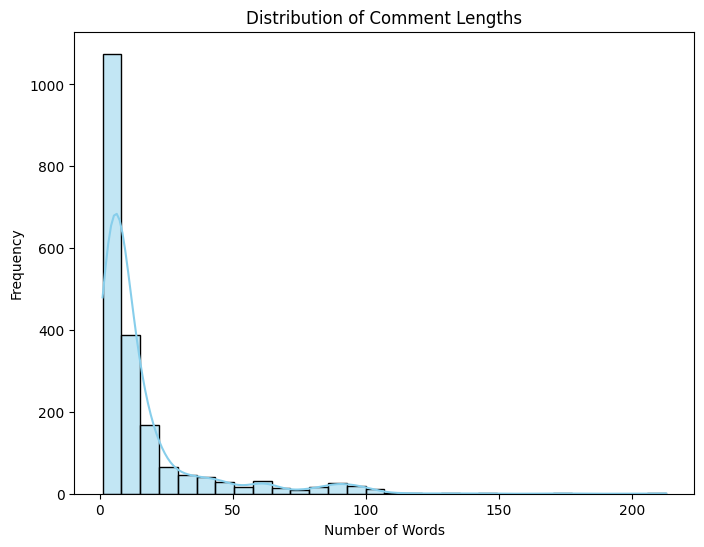

In [ ]:
# EDA Visualization: Target distribution (Spam vs Non-Spam)
plot_target_distribution(df['CLASS'])

# Word Cloud of all comments
plot_word_cloud(df['CONTENT'], title="Word Cloud for YouTube Comments")

# Word Frequency Distribution (Top 20 Words)
plot_word_frequency(df['CONTENT'], top_n=20)

# Comment Length Distribution
plot_comment_length_distribution(df['CONTENT'])



Logistic Regression Results:
Accuracy: 0.9489795918367347
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       176
           1       0.97      0.94      0.95       216

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392


Random Forest Results:
Accuracy: 0.951530612244898
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       176
           1       0.97      0.94      0.96       216

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392


SVM Kernel Function: linear
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       176
           1       0.97      0.95      0.96       216

    accuracy                           0.

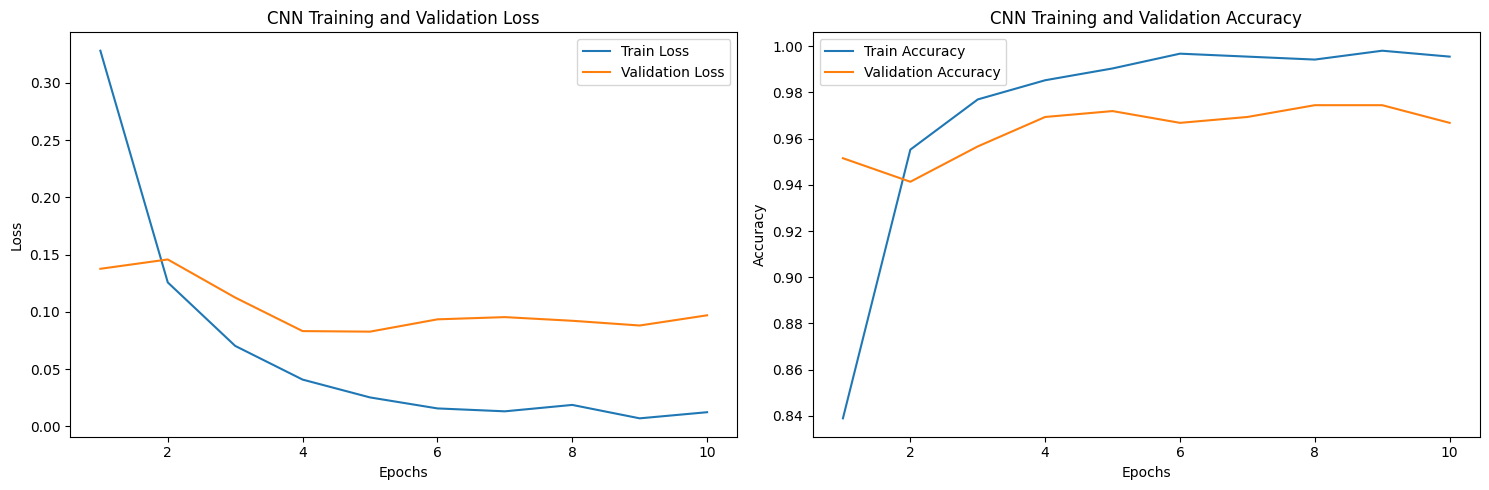

In [ ]:

df = pd.read_csv('/content/Youtube-Spam-Dataset.csv')

df.drop(['COMMENT_ID', 'AUTHOR'], axis=1, inplace=True)

df["CONTENT"] = df["CONTENT"].fillna('')
#df["CONTENT"] = df["CONTENT"].str.replace(r"http\S+", "")
#df["CONTENT"] = df["CONTENT"].str.replace(r"http", "")
df["CONTENT"] = df["CONTENT"].str.replace(r"@\S+", "")
df["CONTENT"] = df["CONTENT"].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
df["CONTENT"] = df["CONTENT"].str.replace(r"@", "at")
df["CONTENT"] = df["CONTENT"].str.lower()

# Prepare data
X = df['CONTENT']
y = df['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train traditional ML models
lr_model, lr_pred = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test)
rf_model, rf_pred = train_random_forest(X_train_tfidf, X_test_tfidf, y_train, y_test)
svm_model, svm_pred = train_svm_models(X_train_tfidf, X_test_tfidf, y_train, y_test)

# Prepare for CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create datasets and dataloaders
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len=128)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize CNN
vocab_size = len(tokenizer.vocab)
cnn_model = TextCNN(vocab_size, embed_dim=128, num_classes=2,
                    kernel_sizes=[3, 4, 5], num_filters=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train CNN
epochs = 10
cnn_train_losses, cnn_val_losses = [], []
cnn_train_accuracies, cnn_val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_cnn(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_cnn(cnn_model, test_loader, criterion, device)

    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    cnn_train_accuracies.append(train_acc)
    cnn_val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Final evaluation
_, cnn_accuracy = evaluate_cnn(cnn_model, test_loader, criterion, device)

# Plot results
plot_training_curves(cnn_train_losses, cnn_val_losses,
                    cnn_train_accuracies, cnn_val_accuracies, epochs)



In [ ]:
# Train XGBoost model
xgb_model, xgb_pred = train_xgboost(X_train_tfidf, X_test_tfidf, y_train, y_test)



XGBoost Results:
Accuracy: 0.9438775510204082
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       176
           1       0.98      0.92      0.95       216

    accuracy                           0.94       392
   macro avg       0.94      0.95      0.94       392
weighted avg       0.95      0.94      0.94       392



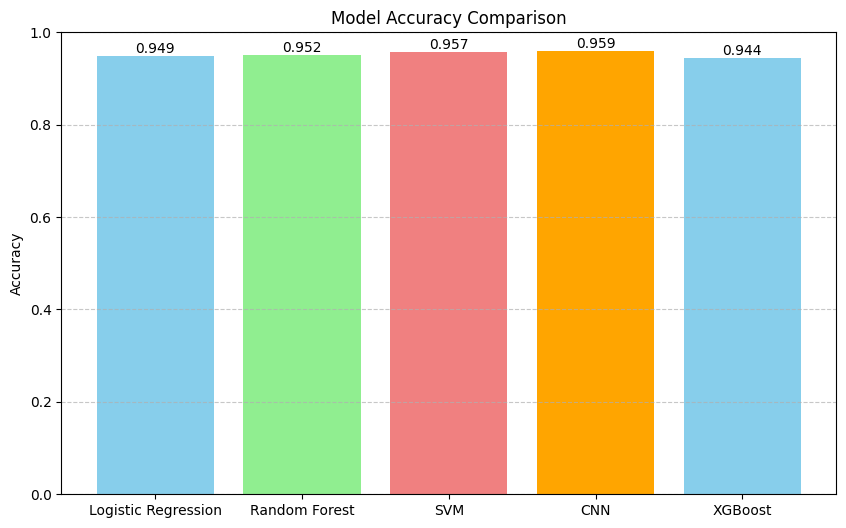

In [ ]:
accuracies = {
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Random Forest': accuracy_score(y_test, rf_pred),
    'SVM': accuracy_score(y_test, svm_pred),
    'CNN': cnn_accuracy,
    'XGBoost': accuracy_score(y_test, xgb_pred)
}

# Plot comparison
plot_model_comparison(accuracies)

BERT

In [ ]:
pip install transformers


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [ ]:
class BertTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove the batch dimension

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
def train_bert_model(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate_bert_model(eval_loader, model, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

    return total_loss / len(eval_loader), correct / len(eval_loader.dataset)


In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare datasets and dataloaders for BERT
max_len = 128  # Maximum sequence length for BERT
train_dataset = BertTextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len)
val_dataset = BertTextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the BERT model for sequence classification (binary classification: 2 classes)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Set optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set loss criterion (CrossEntropyLoss is used for classification)
criterion = nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train Loss: 0.2853, Train Accuracy: 0.9028
Validation Loss: 0.1132, Validation Accuracy: 0.9566
Epoch 2/3
Train Loss: 0.0830, Train Accuracy: 0.9719
Validation Loss: 0.0844, Validation Accuracy: 0.9770
Epoch 3/3
Train Loss: 0.0349, Train Accuracy: 0.9872
Validation Loss: 0.1085, Validation Accuracy: 0.9719


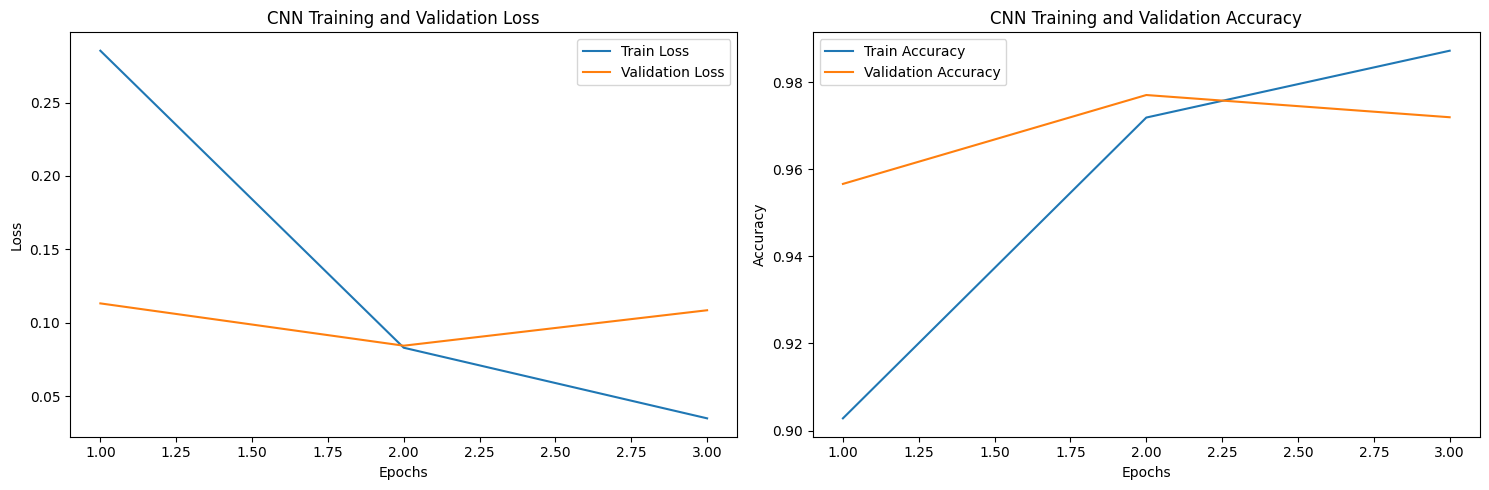

In [ ]:
epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train the model
    train_loss, train_acc = train_bert_model(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model
    val_loss, val_acc = evaluate_bert_model(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Plot training curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
